# https://www.kaggle.com/c/mercari-price-suggestion-challenge 
# https://www.kaggle.com/c/home-credit-default-risk

Выбрать одно из двух соревнований. Выбирайте по данным, с которыми вам интереснее работать.

In [1]:
from __future__ import print_function
import time
import re
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, PolynomialFeatures

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

# Ансамбли

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None

Using TensorFlow backend.
/Users/mary/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Задание
1. Сделать baseline submission
  * Исследовать признак price (TARGET). 
  * Исследовать признак price (TARGET) в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
  * ...
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Скорректировать план
  * убрать пункты, которые кажутся неудачными
  * добавить идеи из kernel, кажущиеся удачными
7. Построить модель, выбрать лучшую
8. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
9. Применить и засабмитить лучшую на cv модель
10. Прислать блокнот и свой ник в лидерборде

# Будем использовать датасет из соревнования Home Credit Default Risk

### Используйте параметр nrows, чтобы уменьшить выборку и сделать базовый разведочный анализ данных

In [2]:
df_train = pd.read_csv('home-credit-default-risk/application_train.csv')
df_test = pd.read_csv('home-credit-default-risk/application_test.csv')

In [3]:
print(df_train.info())
print()
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


In [4]:
df = pd.read_csv('home-credit-default-risk/application_train.csv', nrows=10000)

In [5]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,nan,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,nan,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,nan,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,135000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,-4260.00,-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.56,0.73,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.0

## 1. EDA + Baseline

Посмотрим, насколько сбалансированны классы в выборке

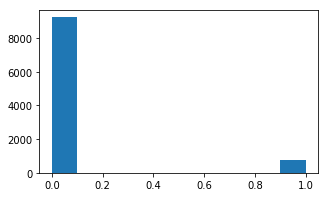

In [6]:
plt.figure(figsize=(5,3))
plt.hist(df.TARGET);

In [7]:
vals, counts = np.unique(df.TARGET, return_counts=True)
dict(zip(vals, counts))

{0: 9225, 1: 775}

Объектов с TARGET == 1 очень мало: <10%, выборка неоднородна.

Теперь выведем информацию по отсутствующим значениям:

In [8]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
df_both=pd.concat([df_train.drop(columns=['TARGET', 'SK_ID_CURR']), df_train.drop(columns=['SK_ID_CURR'])], 
                  axis=0)
missing_values = missing_values_table(df_both).reset_index()
missing_values

/Users/mary/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Selected dataframe has 121 columns.
There are 68 columns that have missing values.


,index,Missing Values,% of Total Values
0,COMMONAREA_AVG,429730,69.90
1,COMMONAREA_MODE,429730,69.90
2,COMMONAREA_MEDI,429730,69.90
3,NONLIVINGAPARTMENTS_MODE,427028,69.40
4,NONLIVINGAPARTMENTS_MEDI,427028,69.40
5,NONLIVINGAPARTMENTS_AVG,427028,69.40
6,FONDKAPREMONT_MODE,420590,68.40
7,LIVINGAPARTMENTS_MODE,420398,68.40
8,LIVINGAPARTMENTS_MEDI,420398,68.40
9,LIVINGAPARTMENTS_AVG,420398,68.40


Поскольку есть признаки с весьма большим количеством пропущенных наблюдений, имеет смысл во время препроцессинга разделить такие признаки по наличию значения (есть/нет). 

Посмотрим, сколько категорий присутствует в категориальных признаках и сколько вообще таких признаков:

In [9]:
print(df.dtypes.value_counts())
cats=pd.Series(df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0), name='num_categories'
         ).reset_index()
cats

float64    65
int64      41
object     16
dtype: int64


,index,num_categories
0,NAME_CONTRACT_TYPE,2
1,CODE_GENDER,3
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,NAME_TYPE_SUITE,7
5,NAME_INCOME_TYPE,8
6,NAME_EDUCATION_TYPE,5
7,NAME_FAMILY_STATUS,6
8,NAME_HOUSING_TYPE,6
9,OCCUPATION_TYPE,18


В качестве бейзлайн модели, возьмем сразу градиентный бустинг (LGBM), но без настройки параметров (предобработку осуществим примитивным способом)

In [10]:
# simple preprocess
base_x, base_y = df_train.dropna().drop(columns=['TARGET', 'SK_ID_CURR']), df_train.dropna().TARGET
base_test = df_test.drop(columns=['SK_ID_CURR'])

noncategorical = base_x.columns[base_x.columns.isin(list(cats['index']))]

for col in base_x.columns:
    if base_x[col].dtype == 'object':
        base_x.loc[base_x[col].isna(), col] = 'nan'
        base_test.loc[base_test[col].isna(), col]='nan'
        
        le=LabelEncoder()
        le.fit(pd.concat([base_x, base_test], axis=0)[col])
        
        base_x[col] = le.transform(base_x[col])
        base_test[col] = le.transform(base_test[col].astype('str'))

imp = SimpleImputer(strategy='mean')
imp.fit(pd.concat([base_x, base_test], axis=0)[noncategorical])

base_x[noncategorical]=imp.transform(base_x[noncategorical])
base_test[noncategorical]=imp.transform(base_test[noncategorical])


# fit
xgboost = xgb.XGBClassifier()
xgboost.fit(base_x, base_y)

# predict
y_pred_xgb = xgboost.predict_proba(base_test)[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_xgb_baseline.csv', sep=',', index=False)
# Kaggle Score = 0.61723

cross_validate(xgboost, base_x, base_y, scoring=['roc_auc'], cv=5)

{'fit_time': array([4.69045091, 4.43580294, 4.39380097, 4.77316904, 4.88001394]),
 'score_time': array([0.02817202, 0.01519203, 0.01441789, 0.01736808, 0.01609707]),
 'test_roc_auc': array([0.73229965, 0.73093322, 0.7250774 , 0.72352057, 0.73649418])}

## 2. Преобразование и добавление признаков. Цикл анализа.

Признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации

* NaN: если в значениях признака >20% пропущено, то разобьем колонку на 2-е: 1)значения после Imputing 2)было ли значение или NaN; остальные пропуски заменим средним
* Закодируем категориальные
* Дополним тренировочный датасет наблюдениями с TARGET=1
* Random Forest для определения значимости признаков

In [11]:
missing_values.head(3)

,index,Missing Values,% of Total Values
0,COMMONAREA_AVG,429730,69.90
1,COMMONAREA_MODE,429730,69.90
2,COMMONAREA_MEDI,429730,69.90


In [12]:
x_train, y_train=df_train.drop(columns=['TARGET', 'SK_ID_CURR']), df_train.TARGET
x_test=df_test.drop(columns=['SK_ID_CURR'])

# NaNs
def manage_nans(x_train, x_test):
    impute_mean=[]
    impute_most_frequent=[]

    for col in list(missing_values[missing_values['index']!='TARGET']['index']):
        if np.sum(missing_values[missing_values['index']==col]['% of Total Values']) > 20:
            if x_train[col].dtype=='object':
                x_train.loc[x_train[col].isna(), col] = 'nan'
                x_test.loc[x_test[col].isna(), col] = 'nan'
            else:
                x_train[col+'_1']=x_train[col].apply(lambda x: 0 if np.isnan(x) else 1)
                x_test[col+'_1']=x_test[col].apply(lambda x: 0 if np.isnan(x) else 1)

                impute_mean.append(col)
        else:
            if x_train[col].dtype=='object':
                impute_most_frequent.append(col)
            else:
                impute_mean.append(col)

    imp = SimpleImputer(strategy='mean')
    imp_cat = SimpleImputer(strategy='most_frequent')
    
    imp.fit(pd.concat([x_train, x_test], axis=0)[impute_mean])
    imp_cat.fit(pd.concat([x_train, x_test], axis=0)[impute_most_frequent])
    
    x_train[impute_mean]=imp.transform(x_train[impute_mean])
    x_train[impute_most_frequent]=imp_cat.transform(x_train[impute_most_frequent])

    x_test[impute_mean]=imp.transform(x_test[impute_mean])
    x_test[impute_most_frequent]=imp_cat.transform(x_test[impute_most_frequent])
    
    return x_train, x_test

Чтобы применять OneHot к категориальным фичам, количество возможных значений этих фичей в тестовой выборке и тренировочной должно совпадать, проверим, так ли это в нашем случае:

In [13]:
print('Train shape:   Test shape:')
pd.get_dummies(df_train).shape, pd.get_dummies(df_test).shape

Train shape:   Test shape:


((307511, 246), (48744, 242))

In [14]:
df_train.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,351000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,-3648.00,-2120,nan,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,-1134.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,1129500.00,Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,-1186.00,-291,nan,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,nan,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00


В нашем случае указанные размерности не совпадают, поэтому нужно взять пересечение имеющихся признаков в train и test сетах

In [15]:
def categories_encoding(df_train, df_test):
    
    df_train = pd.get_dummies(df_train)
    df_test = pd.get_dummies(df_test)

    # Align the training and testing data, keep only columns present in both dataframes
    df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

    print('Training Features shape: ', df_train.shape)
    print('Testing Features shape: ', df_test.shape)
    
    return df_train, df_test

In [16]:
x_train, x_test = manage_nans(x_train, x_test)
x_train, x_test = categories_encoding(x_train, x_test)

Training Features shape:  (307511, 291)
Testing Features shape:  (48744, 291)


In [17]:
# Balance classes
smt = SMOTE()

x_train_smt, y_train_smt = smt.fit_sample(x_train, y_train)
col_x=x_train.columns
col_y=y_train.name

x_train=pd.DataFrame(x_train_smt, columns=col_x)
y_train=pd.Series(y_train_smt, name=col_y)

pd.Series(y_train).value_counts()

1    282686
0    282686
Name: TARGET, dtype: int64

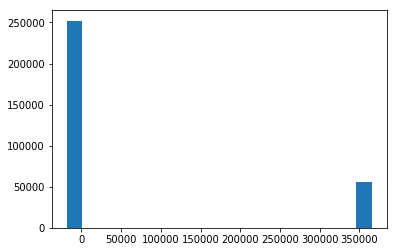

In [18]:
plt.hist(df_train['DAYS_EMPLOYED'],bins=20);

In [19]:
x_train[x_train.DAYS_EMPLOYED > 300000].shape

(86555, 291)

In [20]:
x_train[x_train.DAYS_EMPLOYED > 300000].DAYS_EMPLOYED.unique()

array([365243.        , 360626.56084651])

Разобьем DAYS_EMPLOYED на две колонки: 1) до 300 000 (остальное Impute-им) 2) более 300 000 (остальное =0), так как большие значения с одной стороны похожи на выбросы, но с другой их достаточно много, и мы можем потерять значимые данные простым импьютом

In [21]:
x_train['DAYS_EMPLOYED_OUTLIERS'] = x_train.DAYS_EMPLOYED.apply(lambda x: x if x>300000 else np.nan).fillna(0)

m=np.mean(x_train.DAYS_EMPLOYED)
x_train['DAYS_EMPLOYED']=x_train.DAYS_EMPLOYED.apply(lambda x: x if x<300000 else m).fillna(0)

In [22]:
x_test['DAYS_EMPLOYED_OUTLIERS'] = x_test.DAYS_EMPLOYED.apply(lambda x: x if x>300000 else np.nan).fillna(0)

m=np.mean(x_test.DAYS_EMPLOYED)
x_test['DAYS_EMPLOYED']=x_test.DAYS_EMPLOYED.apply(lambda x: x if x<300000 else m).fillna(0)

Далее отскейлим признаки

In [23]:
scaler=StandardScaler()
scaler.fit(pd.concat([x_train, x_test], axis=0))

x_train=pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test=pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [24]:
x_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMONAREA_AVG_1,COMMONAREA_MODE_1,COMMONAREA_MEDI_1,NONLIVINGAPARTMENTS_MODE_1,NONLIVINGAPARTMENTS_MEDI_1,NONLIVINGAPARTMENTS_AVG_1,LIVINGAPARTMENTS_MODE_1,LIVINGAPARTMENTS_MEDI_1,LIVINGAPARTMENTS_AVG_1,FLOORSMIN_AVG_1,FLOORSMIN_MODE_1,FLOORSMIN_MEDI_1,YEARS_BUILD_MEDI_1,YEARS_BUILD_AVG_1,YEARS_BUILD_MODE_1,OWN_CAR_AGE_1,LANDAREA_MEDI_1,LANDAREA_AVG_1,LANDAREA_MODE_1,BASEMENTAREA_MEDI_1,BASEMENTAREA_MODE_1,BASEMENTAREA_AVG_1,EXT_SOURCE_1_1,NONLIVINGAREA_AVG_1,NONLIVINGAREA_MODE_1,NONLIVINGAREA_MEDI_1,ELEVATORS_MODE_1,ELEVATORS_MEDI_1,ELEVATORS_AVG_1,APARTMENTS_AVG_1,APARTMENTS_MODE_1,APARTMENTS_MEDI_1,ENTRANCES_MEDI_1,ENTRANCES_MODE_1,ENTRANCES_AVG_1,LIVINGAREA_AVG_1,LIVINGAREA_MEDI_1,LIVINGAREA_MODE_1,FLOORSMAX_AVG_1,FLOORSMAX_MEDI_1,FLOORSMAX_MODE_1,YEARS_BEGINEXPLUATATION_MEDI_1,YEARS_BEGINEXPLUATATION_AVG_1,YEARS_BEGINEXPLUATATION_MODE_1,TOTALAREA_MODE_1,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core sta

In [25]:
# Find importance
t_start = time.time()
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
rnd_clf.fit(x_train, y_train)

t_end = time.time()
print('time for training is {} minutes'.format((t_end - t_start)/60))

/Users/mary/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time for training is 0.37424199978510536 minutes


In [26]:
perc=0.02
rfc_imp_frame=pd.DataFrame({
    'column':x_train.columns, 
    'importance':rnd_clf.feature_importances_}).sort_values(by='importance', ascending=False)
print('Признаков важностью >= {} всего '.format(perc) + str(rfc_imp_frame[rfc_imp_frame.importance >= perc].shape[0]))
rfc_imp_features = rfc_imp_frame[rfc_imp_frame.importance >= perc].column
rfc_imp_frame[rfc_imp_frame.importance >= perc]

Признаков важностью >= 0.02 всего 9


,column,importance
142,FLOORSMAX_AVG_1,0.04
133,APARTMENTS_AVG_1,0.04
143,FLOORSMAX_MEDI_1,0.04
29,EXT_SOURCE_3,0.03
152,CODE_GENDER_M,0.03
151,CODE_GENDER_F,0.02
126,EXT_SOURCE_1_1,0.02
154,FLAG_OWN_CAR_Y,0.02
28,EXT_SOURCE_2,0.02


Теперь построим модель LGBM на всех признаках после предобработки и настроим параметры

In [27]:
def gridsearch_cv(model, param_grid, x_train=x_train, y_train=y_train):
    grid_search = GridSearchCV(model, param_grid, cv=4, scoring='roc_auc')
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} minutes'.format((t_end - t_start)/60))
    print(grid_search.best_score_)
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    return grid_search

In [29]:
# LGBM

param_grid = {'n_estimators': [50, 70, 100],
             'n_jobs':[-1],
             'random_state':[42]}
light = gridsearch_cv(lgb.LGBMClassifier(), param_grid)

model LGBMClassifier best accuracy score is 0.9698481553329416
time for training is 17.683209482828776 minutes
0.9698481553329416
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'n_estimators': 50, 'n_jobs': -1, 'random_state': 42}


In [33]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1]}
light = gridsearch_cv(light.best_estimator_, param_grid)

model LGBMClassifier best accuracy score is 0.971244635615703
time for training is 16.559313635031383 minutes
0.971244635615703
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'learning_rate': 0.05}


In [36]:
param_grid = {'max_depth': [3, 4, 5, 6]}
light = gridsearch_cv(light.best_estimator_, param_grid)

model LGBMClassifier best accuracy score is 0.9706569302675339
time for training is 14.443997701009115 minutes
0.9706569302675339
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'max_depth': 5}


In [38]:
param_grid = {'reg_alpha': [0, 0.5, 1, 1.5]}
light = gridsearch_cv(light.best_estimator_, param_grid)

model LGBMClassifier best accuracy score is 0.9706569302675339
time for training is 20.06013913154602 minutes
0.9706569302675339
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'reg_alpha': 0}


In [39]:
param_grid = {'reg_lambda': [0, 0.5, 1, 3]}
light = gridsearch_cv(light.best_estimator_, param_grid)

light_best_model = light.best_estimator_

model LGBMClassifier best accuracy score is 0.9706569302675339
time for training is 19.752779348691305 minutes
0.9706569302675339
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0, reg_lambda=0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'reg_lambda': 0}


In [43]:
# CatBoost

param_grid = {'iterations': [50, 60, 70],
             'random_state':[42],
             'learning_rate':[0.1]}
cbc = gridsearch_cv(CatBoostClassifier(), param_grid)

0:	learn: 0.5531898	total: 774ms	remaining: 37.9s
1:	learn: 0.4492869	total: 1.47s	remaining: 35.3s
2:	learn: 0.3578151	total: 2.15s	remaining: 33.7s
3:	learn: 0.2867698	total: 2.82s	remaining: 32.4s
4:	learn: 0.2380297	total: 3.53s	remaining: 31.8s
5:	learn: 0.2031850	total: 4.14s	remaining: 30.3s
6:	learn: 0.1690985	total: 4.77s	remaining: 29.3s
7:	learn: 0.1410396	total: 5.41s	remaining: 28.4s
8:	learn: 0.1203291	total: 5.96s	remaining: 27.1s
9:	learn: 0.1031791	total: 6.54s	remaining: 26.2s
10:	learn: 0.0900726	total: 7.07s	remaining: 25.1s
11:	learn: 0.0762560	total: 7.6s	remaining: 24.1s
12:	learn: 0.0663032	total: 8.28s	remaining: 23.6s
13:	learn: 0.0574397	total: 8.93s	remaining: 23s
14:	learn: 0.0506782	total: 9.63s	remaining: 22.5s
15:	learn: 0.0451121	total: 10.2s	remaining: 21.7s
16:	learn: 0.0400578	total: 10.8s	remaining: 21s
17:	learn: 0.0358258	total: 11.4s	remaining: 20.3s
18:	learn: 0.0317599	total: 12.1s	remaining: 19.7s
19:	learn: 0.0285943	total: 12.7s	remaining: 1

13:	learn: 0.2089713	total: 9.42s	remaining: 24.2s
14:	learn: 0.2046772	total: 10s	remaining: 23.4s
15:	learn: 0.2017296	total: 10.6s	remaining: 22.5s
16:	learn: 0.1975469	total: 11.1s	remaining: 21.6s
17:	learn: 0.1948488	total: 11.7s	remaining: 20.8s
18:	learn: 0.1910478	total: 12.3s	remaining: 20s
19:	learn: 0.1886801	total: 12.8s	remaining: 19.2s
20:	learn: 0.1871299	total: 13.3s	remaining: 18.4s
21:	learn: 0.1856823	total: 13.8s	remaining: 17.6s
22:	learn: 0.1845995	total: 14.3s	remaining: 16.8s
23:	learn: 0.1837506	total: 14.8s	remaining: 16.1s
24:	learn: 0.1830470	total: 15.3s	remaining: 15.3s
25:	learn: 0.1824615	total: 15.9s	remaining: 14.7s
26:	learn: 0.1809795	total: 16.4s	remaining: 14s
27:	learn: 0.1804009	total: 17s	remaining: 13.3s
28:	learn: 0.1790815	total: 17.5s	remaining: 12.7s
29:	learn: 0.1786215	total: 18s	remaining: 12s
30:	learn: 0.1783079	total: 18.4s	remaining: 11.3s
31:	learn: 0.1779582	total: 18.9s	remaining: 10.6s
32:	learn: 0.1771784	total: 19.4s	remaining

6:	learn: 0.2862833	total: 5.51s	remaining: 41.7s
7:	learn: 0.2678867	total: 6.16s	remaining: 40s
8:	learn: 0.2539660	total: 6.79s	remaining: 38.5s
9:	learn: 0.2430274	total: 7.28s	remaining: 36.4s
10:	learn: 0.2329657	total: 7.84s	remaining: 34.9s
11:	learn: 0.2261798	total: 8.45s	remaining: 33.8s
12:	learn: 0.2180781	total: 9.04s	remaining: 32.7s
13:	learn: 0.2113930	total: 9.61s	remaining: 31.6s
14:	learn: 0.2064705	total: 10.2s	remaining: 30.6s
15:	learn: 0.2018680	total: 10.8s	remaining: 29.8s
16:	learn: 0.1981896	total: 11.3s	remaining: 28.7s
17:	learn: 0.1946751	total: 11.9s	remaining: 27.7s
18:	learn: 0.1923994	total: 12.5s	remaining: 26.9s
19:	learn: 0.1893759	total: 12.9s	remaining: 25.8s
20:	learn: 0.1867937	total: 13.5s	remaining: 25.1s
21:	learn: 0.1855356	total: 14s	remaining: 24.2s
22:	learn: 0.1845558	total: 14.4s	remaining: 23.2s
23:	learn: 0.1829734	total: 14.9s	remaining: 22.4s
24:	learn: 0.1821451	total: 15.5s	remaining: 21.6s
25:	learn: 0.1812258	total: 16s	remaini

49:	learn: 0.0043100	total: 28.2s	remaining: 11.3s
50:	learn: 0.0042674	total: 28.6s	remaining: 10.7s
51:	learn: 0.0042179	total: 29.1s	remaining: 10.1s
52:	learn: 0.0040773	total: 29.5s	remaining: 9.46s
53:	learn: 0.0039166	total: 30s	remaining: 8.9s
54:	learn: 0.0038922	total: 30.5s	remaining: 8.31s
55:	learn: 0.0038629	total: 30.9s	remaining: 7.73s
56:	learn: 0.0038475	total: 31.3s	remaining: 7.14s
57:	learn: 0.0038100	total: 31.8s	remaining: 6.58s
58:	learn: 0.0037931	total: 32.3s	remaining: 6.02s
59:	learn: 0.0037610	total: 32.7s	remaining: 5.46s
60:	learn: 0.0037297	total: 33.2s	remaining: 4.9s
61:	learn: 0.0037038	total: 33.6s	remaining: 4.34s
62:	learn: 0.0036989	total: 34s	remaining: 3.78s
63:	learn: 0.0036877	total: 34.4s	remaining: 3.23s
64:	learn: 0.0035548	total: 34.8s	remaining: 2.68s
65:	learn: 0.0034685	total: 35.3s	remaining: 2.14s
66:	learn: 0.0034499	total: 35.7s	remaining: 1.6s
67:	learn: 0.0033452	total: 36.2s	remaining: 1.06s
68:	learn: 0.0033247	total: 36.7s	rema

2:	learn: 0.4406198	total: 2.22s	remaining: 49.6s
3:	learn: 0.3961750	total: 2.81s	remaining: 46.3s
4:	learn: 0.3484282	total: 3.46s	remaining: 45s
5:	learn: 0.3070750	total: 4.13s	remaining: 44s
6:	learn: 0.2875035	total: 4.79s	remaining: 43.1s
7:	learn: 0.2686117	total: 5.45s	remaining: 42.3s
8:	learn: 0.2511275	total: 5.99s	remaining: 40.6s
9:	learn: 0.2397031	total: 6.62s	remaining: 39.7s
10:	learn: 0.2304612	total: 7.26s	remaining: 39s
11:	learn: 0.2216458	total: 7.86s	remaining: 38s
12:	learn: 0.2151080	total: 8.44s	remaining: 37s
13:	learn: 0.2089713	total: 9.05s	remaining: 36.2s
14:	learn: 0.2046772	total: 9.65s	remaining: 35.4s
15:	learn: 0.2017296	total: 10.2s	remaining: 34.4s
16:	learn: 0.1975469	total: 10.7s	remaining: 33.5s
17:	learn: 0.1948488	total: 11.3s	remaining: 32.7s
18:	learn: 0.1910478	total: 11.9s	remaining: 31.8s
19:	learn: 0.1886801	total: 12.4s	remaining: 31s
20:	learn: 0.1871299	total: 12.9s	remaining: 30.1s
21:	learn: 0.1856823	total: 13.4s	remaining: 29.3s


In [44]:
param_grid = {'depth': [3, 5, 7]}
cbc = gridsearch_cv(cbc.best_estimator_, param_grid)

0:	learn: 0.5838028	total: 510ms	remaining: 25s
1:	learn: 0.5212119	total: 1s	remaining: 24.1s
2:	learn: 0.4585550	total: 1.4s	remaining: 22s
3:	learn: 0.3984792	total: 1.9s	remaining: 21.8s
4:	learn: 0.3590648	total: 2.38s	remaining: 21.5s
5:	learn: 0.3212276	total: 2.78s	remaining: 20.4s
6:	learn: 0.2985511	total: 3.31s	remaining: 20.3s
7:	learn: 0.2731475	total: 3.75s	remaining: 19.7s
8:	learn: 0.2425888	total: 4.18s	remaining: 19s
9:	learn: 0.2212462	total: 4.61s	remaining: 18.5s
10:	learn: 0.2059743	total: 5.03s	remaining: 17.8s
11:	learn: 0.1904920	total: 5.4s	remaining: 17.1s
12:	learn: 0.1689399	total: 5.79s	remaining: 16.5s
13:	learn: 0.1486774	total: 6.2s	remaining: 15.9s
14:	learn: 0.1342088	total: 6.56s	remaining: 15.3s
15:	learn: 0.1209333	total: 6.9s	remaining: 14.7s
16:	learn: 0.1092595	total: 7.25s	remaining: 14.1s
17:	learn: 0.0989128	total: 7.61s	remaining: 13.5s
18:	learn: 0.0893309	total: 7.96s	remaining: 13s
19:	learn: 0.0819026	total: 8.37s	remaining: 12.6s
20:	le

13:	learn: 0.2584204	total: 6.97s	remaining: 17.9s
14:	learn: 0.2492438	total: 7.37s	remaining: 17.2s
15:	learn: 0.2372562	total: 7.79s	remaining: 16.6s
16:	learn: 0.2310189	total: 8.17s	remaining: 15.9s
17:	learn: 0.2275330	total: 8.59s	remaining: 15.3s
18:	learn: 0.2234649	total: 8.94s	remaining: 14.6s
19:	learn: 0.2209219	total: 9.3s	remaining: 14s
20:	learn: 0.2162524	total: 9.67s	remaining: 13.3s
21:	learn: 0.2143767	total: 10s	remaining: 12.8s
22:	learn: 0.2125308	total: 10.4s	remaining: 12.3s
23:	learn: 0.2111088	total: 10.8s	remaining: 11.7s
24:	learn: 0.2067769	total: 11.2s	remaining: 11.2s
25:	learn: 0.2056801	total: 11.5s	remaining: 10.6s
26:	learn: 0.2046187	total: 11.9s	remaining: 10.1s
27:	learn: 0.2037206	total: 12.2s	remaining: 9.6s
28:	learn: 0.2010131	total: 12.6s	remaining: 9.11s
29:	learn: 0.1989465	total: 12.9s	remaining: 8.62s
30:	learn: 0.1961047	total: 13.4s	remaining: 8.2s
31:	learn: 0.1929091	total: 13.7s	remaining: 7.72s
32:	learn: 0.1922207	total: 14.1s	rema

26:	learn: 0.1864815	total: 14.8s	remaining: 12.6s
27:	learn: 0.1859893	total: 15.2s	remaining: 12s
28:	learn: 0.1854945	total: 15.7s	remaining: 11.3s
29:	learn: 0.1850074	total: 16.1s	remaining: 10.7s
30:	learn: 0.1845186	total: 16.6s	remaining: 10.2s
31:	learn: 0.1820979	total: 17s	remaining: 9.59s
32:	learn: 0.1809452	total: 17.5s	remaining: 9s
33:	learn: 0.1804950	total: 17.9s	remaining: 8.43s
34:	learn: 0.1792306	total: 18.3s	remaining: 7.86s
35:	learn: 0.1789332	total: 18.8s	remaining: 7.3s
36:	learn: 0.1780573	total: 19.2s	remaining: 6.75s
37:	learn: 0.1777623	total: 19.6s	remaining: 6.2s
38:	learn: 0.1775520	total: 20.1s	remaining: 5.66s
39:	learn: 0.1772894	total: 20.6s	remaining: 5.14s
40:	learn: 0.1771261	total: 21s	remaining: 4.61s
41:	learn: 0.1769161	total: 21.5s	remaining: 4.09s
42:	learn: 0.1767258	total: 21.9s	remaining: 3.57s
43:	learn: 0.1765452	total: 22.3s	remaining: 3.05s
44:	learn: 0.1763768	total: 22.7s	remaining: 2.53s
45:	learn: 0.1762357	total: 23.2s	remainin

39:	learn: 0.1743742	total: 26.3s	remaining: 6.57s
40:	learn: 0.1742148	total: 26.9s	remaining: 5.91s
41:	learn: 0.1740616	total: 27.5s	remaining: 5.24s
42:	learn: 0.1739314	total: 28.1s	remaining: 4.57s
43:	learn: 0.1738106	total: 28.7s	remaining: 3.91s
44:	learn: 0.1736364	total: 29.2s	remaining: 3.25s
45:	learn: 0.1735249	total: 29.7s	remaining: 2.58s
46:	learn: 0.1734177	total: 30.3s	remaining: 1.93s
47:	learn: 0.1732941	total: 30.9s	remaining: 1.29s
48:	learn: 0.1731122	total: 31.5s	remaining: 644ms
49:	learn: 0.1729761	total: 32.2s	remaining: 0us
0:	learn: 0.5536230	total: 1.16s	remaining: 56.6s
1:	learn: 0.4920622	total: 1.99s	remaining: 47.7s
2:	learn: 0.4291679	total: 2.75s	remaining: 43.1s
3:	learn: 0.3722226	total: 3.47s	remaining: 40s
4:	learn: 0.3301332	total: 4.17s	remaining: 37.5s
5:	learn: 0.2983997	total: 4.95s	remaining: 36.3s
6:	learn: 0.2759696	total: 5.76s	remaining: 35.4s
7:	learn: 0.2591002	total: 6.53s	remaining: 34.3s
8:	learn: 0.2458294	total: 7.18s	remaining:

In [45]:
param_grid = {'learning_rate': [1, 0.1, 0.01, 0.001]}
cbc = gridsearch_cv(cbc.best_estimator_, param_grid)

cbc_best_model = cbc.best_estimator_

0:	learn: 0.4433126	total: 557ms	remaining: 27.3s
1:	learn: 0.3163284	total: 1.09s	remaining: 26.2s
2:	learn: 0.2228296	total: 1.54s	remaining: 24.2s
3:	learn: 0.1434278	total: 1.94s	remaining: 22.3s
4:	learn: 0.1138336	total: 2.32s	remaining: 20.8s
5:	learn: 0.0870598	total: 2.75s	remaining: 20.1s
6:	learn: 0.0556771	total: 3.15s	remaining: 19.4s
7:	learn: 0.0395792	total: 3.57s	remaining: 18.7s
8:	learn: 0.0264650	total: 3.97s	remaining: 18.1s
9:	learn: 0.0202158	total: 4.42s	remaining: 17.7s
10:	learn: 0.0161741	total: 4.86s	remaining: 17.2s
11:	learn: 0.0117947	total: 5.26s	remaining: 16.7s
12:	learn: 0.0086683	total: 5.63s	remaining: 16s
13:	learn: 0.0063553	total: 5.99s	remaining: 15.4s
14:	learn: 0.0049737	total: 6.33s	remaining: 14.8s
15:	learn: 0.0047611	total: 6.66s	remaining: 14.2s
16:	learn: 0.0043638	total: 6.99s	remaining: 13.6s
17:	learn: 0.0033743	total: 7.35s	remaining: 13.1s
18:	learn: 0.0033262	total: 7.69s	remaining: 12.5s
19:	learn: 0.0032104	total: 8s	remaining: 1

13:	learn: 0.1809822	total: 5.65s	remaining: 14.5s
14:	learn: 0.1799876	total: 6.15s	remaining: 14.4s
15:	learn: 0.1796120	total: 6.52s	remaining: 13.9s
16:	learn: 0.1791768	total: 6.9s	remaining: 13.4s
17:	learn: 0.1786759	total: 7.27s	remaining: 12.9s
18:	learn: 0.1781957	total: 7.73s	remaining: 12.6s
19:	learn: 0.1777207	total: 8.09s	remaining: 12.1s
20:	learn: 0.1733876	total: 8.42s	remaining: 11.6s
21:	learn: 0.1730760	total: 8.76s	remaining: 11.2s
22:	learn: 0.1728574	total: 9.08s	remaining: 10.7s
23:	learn: 0.1726161	total: 9.41s	remaining: 10.2s
24:	learn: 0.1723366	total: 9.79s	remaining: 9.79s
25:	learn: 0.1721915	total: 10.1s	remaining: 9.33s
26:	learn: 0.1720822	total: 10.4s	remaining: 8.87s
27:	learn: 0.1719177	total: 10.8s	remaining: 8.45s
28:	learn: 0.1716443	total: 11.1s	remaining: 8.04s
29:	learn: 0.1715515	total: 11.4s	remaining: 7.62s
30:	learn: 0.1714345	total: 11.8s	remaining: 7.22s
31:	learn: 0.1713062	total: 12.1s	remaining: 6.8s
32:	learn: 0.1711481	total: 12.5s

26:	learn: 0.1941405	total: 11s	remaining: 9.38s
27:	learn: 0.1915563	total: 11.4s	remaining: 8.99s
28:	learn: 0.1905956	total: 11.8s	remaining: 8.52s
29:	learn: 0.1899144	total: 12.1s	remaining: 8.06s
30:	learn: 0.1892072	total: 12.4s	remaining: 7.62s
31:	learn: 0.1881711	total: 12.8s	remaining: 7.21s
32:	learn: 0.1876281	total: 13.2s	remaining: 6.79s
33:	learn: 0.1859398	total: 13.5s	remaining: 6.37s
34:	learn: 0.1854956	total: 13.8s	remaining: 5.93s
35:	learn: 0.1851103	total: 14.2s	remaining: 5.5s
36:	learn: 0.1847711	total: 14.5s	remaining: 5.09s
37:	learn: 0.1844664	total: 14.8s	remaining: 4.69s
38:	learn: 0.1841678	total: 15.1s	remaining: 4.27s
39:	learn: 0.1839070	total: 15.5s	remaining: 3.87s
40:	learn: 0.1836248	total: 15.8s	remaining: 3.47s
41:	learn: 0.1834146	total: 16.1s	remaining: 3.07s
42:	learn: 0.1832358	total: 16.5s	remaining: 2.68s
43:	learn: 0.1830690	total: 16.8s	remaining: 2.29s
44:	learn: 0.1828848	total: 17.1s	remaining: 1.9s
45:	learn: 0.1827262	total: 17.4s	r

39:	learn: 0.4669875	total: 18.2s	remaining: 4.54s
40:	learn: 0.4622897	total: 18.6s	remaining: 4.08s
41:	learn: 0.4576961	total: 19s	remaining: 3.63s
42:	learn: 0.4547315	total: 19.5s	remaining: 3.17s
43:	learn: 0.4508470	total: 19.9s	remaining: 2.72s
44:	learn: 0.4458016	total: 20.4s	remaining: 2.27s
45:	learn: 0.4420740	total: 20.8s	remaining: 1.81s
46:	learn: 0.4405509	total: 21.3s	remaining: 1.36s
47:	learn: 0.4368403	total: 21.8s	remaining: 907ms
48:	learn: 0.4328456	total: 22.2s	remaining: 453ms
49:	learn: 0.4294098	total: 22.6s	remaining: 0us
0:	learn: 0.6812881	total: 679ms	remaining: 33.3s
1:	learn: 0.6731010	total: 1.16s	remaining: 27.8s
2:	learn: 0.6652912	total: 1.57s	remaining: 24.6s
3:	learn: 0.6545570	total: 2.02s	remaining: 23.2s
4:	learn: 0.6474034	total: 2.43s	remaining: 21.9s
5:	learn: 0.6406996	total: 2.87s	remaining: 21.1s
6:	learn: 0.6310395	total: 3.37s	remaining: 20.7s
7:	learn: 0.6247952	total: 3.81s	remaining: 20s
8:	learn: 0.6160292	total: 4.26s	remaining: 1

2:	learn: 0.6895232	total: 1.64s	remaining: 25.6s
3:	learn: 0.6886649	total: 2.2s	remaining: 25.4s
4:	learn: 0.6874761	total: 2.65s	remaining: 23.9s
5:	learn: 0.6867590	total: 3.05s	remaining: 22.4s
6:	learn: 0.6859137	total: 3.47s	remaining: 21.3s
7:	learn: 0.6850735	total: 3.88s	remaining: 20.4s
8:	learn: 0.6838998	total: 4.31s	remaining: 19.6s
9:	learn: 0.6830639	total: 4.72s	remaining: 18.9s
10:	learn: 0.6819009	total: 5.15s	remaining: 18.3s
11:	learn: 0.6807391	total: 5.61s	remaining: 17.8s
12:	learn: 0.6799088	total: 6.02s	remaining: 17.1s
13:	learn: 0.6790829	total: 6.43s	remaining: 16.5s
14:	learn: 0.6782663	total: 6.83s	remaining: 15.9s
15:	learn: 0.6774553	total: 7.24s	remaining: 15.4s
16:	learn: 0.6766418	total: 7.65s	remaining: 14.9s
17:	learn: 0.6758327	total: 8.2s	remaining: 14.6s
18:	learn: 0.6746914	total: 8.64s	remaining: 14.1s
19:	learn: 0.6735419	total: 9.08s	remaining: 13.6s
20:	learn: 0.6727422	total: 9.5s	remaining: 13.1s
21:	learn: 0.6716020	total: 9.95s	remainin

15:	learn: 0.2110111	total: 9.01s	remaining: 19.1s
16:	learn: 0.2070176	total: 9.58s	remaining: 18.6s
17:	learn: 0.2000206	total: 10.2s	remaining: 18s
18:	learn: 0.1971045	total: 10.7s	remaining: 17.4s
19:	learn: 0.1929365	total: 11.2s	remaining: 16.8s
20:	learn: 0.1865093	total: 11.7s	remaining: 16.1s
21:	learn: 0.1820767	total: 12.1s	remaining: 15.5s
22:	learn: 0.1781757	total: 12.7s	remaining: 14.9s
23:	learn: 0.1750088	total: 13.2s	remaining: 14.2s
24:	learn: 0.1735083	total: 13.6s	remaining: 13.6s
25:	learn: 0.1698150	total: 14.1s	remaining: 13s
26:	learn: 0.1686016	total: 14.6s	remaining: 12.4s
27:	learn: 0.1676793	total: 15s	remaining: 11.8s
28:	learn: 0.1655329	total: 15.6s	remaining: 11.3s
29:	learn: 0.1648048	total: 16.1s	remaining: 10.7s
30:	learn: 0.1641745	total: 16.6s	remaining: 10.2s
31:	learn: 0.1623945	total: 17s	remaining: 9.59s
32:	learn: 0.1617829	total: 17.5s	remaining: 9.01s
33:	learn: 0.1592569	total: 18.1s	remaining: 8.49s
34:	learn: 0.1587861	total: 18.5s	remai

In [46]:
x_train['TARGET']=y_train
corrs = x_train.corr()['TARGET'].sort_values()
x_train.drop(columns='TARGET', inplace=True)

print('Most Positive Correlations:\n', corrs.tail(20))
print('\nMost Negative Correlations:\n', corrs.head(20))

Most Positive Correlations:
 FONDKAPREMONT_MODE_nan                              0.06
LIVE_CITY_NOT_WORK_CITY                             0.07
WALLSMATERIAL_MODE_nan                              0.08
OCCUPATION_TYPE_Laborers                            0.08
HOUSETYPE_MODE_nan                                  0.08
EMERGENCYSTATE_MODE_nan                             0.08
FLAG_DOCUMENT_3                                     0.09
REG_CITY_NOT_LIVE_CITY                              0.09
FLAG_EMP_PHONE                                      0.09
DAYS_ID_PUBLISH                                     0.09
DAYS_REGISTRATION                                   0.10
REG_CITY_NOT_WORK_CITY                              0.10
NAME_EDUCATION_TYPE_Secondary / secondary special   0.10
CODE_GENDER_M                                       0.11
DAYS_LAST_PHONE_CHANGE                              0.11
NAME_INCOME_TYPE_Working                            0.12
REGION_RATING_CLIENT                                0.12
RE

In [47]:
most_corrs=corrs.apply(lambda x: x if abs(x)>=0.11 else np.nan)[:-1].copy().reset_index() #[:-1] - TARGET removal
most_corrs=most_corrs[~most_corrs.TARGET.isna()]['index']
len(most_corrs)

9

Вывели признаки, у которых корреляция с TARGET по модулю >= 0.11 - запомним эти фичи. Далее построим полиномиальные фичи на основе наиболее коррелирующих с таргетом и добавим их к x_train и x_test.

In [48]:
poly_features = x_train[most_corrs].copy()
poly_features_test = x_test[most_corrs].copy()
                                  
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(pd.concat([poly_features, poly_features_test], axis=0))

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

# Get names for new polynomial features
poly_names=poly_transformer.get_feature_names(input_features = list(most_corrs))

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (565372, 220)


In [49]:
poly_features = pd.DataFrame(poly_features, columns = poly_names)
poly_features_test = pd.DataFrame(poly_features_test, columns = poly_names)
poly_features['TARGET'] = y_train

In [50]:
t_start=time.time()

# Find the correlations 
poly_corrs = poly_features.corr()['TARGET'].sort_values()[:-2] # without TARGET and column with ones
poly_features.drop(columns='TARGET', inplace=True)

print('time for training is {} minutes'.format((time.time() - t_start)/60))

# Display most negative and most positive
print(poly_corrs.head(20))
print(poly_corrs.tail(20))

time for training is 1.235050614674886 minutes
NAME_INCOME_TYPE_Working^2                            -0.40
EXT_SOURCE_2                                          -0.30
EXT_SOURCE_3                                          -0.29
EXT_SOURCE_2 NAME_INCOME_TYPE_Working^2               -0.27
EXT_SOURCE_3 NAME_INCOME_TYPE_Working^2               -0.27
EXT_SOURCE_3^3                                        -0.22
NAME_EDUCATION_TYPE_Higher education^3                -0.22
NAME_EDUCATION_TYPE_Higher education^2                -0.22
EXT_SOURCE_2^3                                        -0.20
EXT_SOURCE_3 DAYS_BIRTH^2                             -0.20
EXT_SOURCE_2^2 EXT_SOURCE_3                           -0.20
EXT_SOURCE_2 NAME_EDUCATION_TYPE_Higher education^2   -0.20
EXT_SOURCE_1                                          -0.20
EXT_SOURCE_2 DAYS_BIRTH^2                             -0.19
EXT_SOURCE_2 DAYS_LAST_PHONE_CHANGE^2                 -0.18
EXT_SOURCE_2 EXT_SOURCE_3^2                          

In [51]:
most_corrs_poly=poly_corrs.apply(lambda x: x if abs(x)>=0.10 else np.nan)[:-1].copy().reset_index() 
most_corrs_poly=most_corrs_poly[~most_corrs_poly.TARGET.isna()]['index']
len(most_corrs_poly)

62

На данный момент имеем 3 пула признаков: 
    * наиболее важные с точки зрения корреляции с целевой переменной;
    * наиболее важные с точки зрения корреляции с целевой переменной с учетом полиномиальных фичей;
    * наиболее важные по feature importance в RandomForest;
    
Сформируем последний пул: наиболее важные признаки по feature importance в RandomForest с учетом полиномиальных фичей

In [52]:
poly_rfc_features = x_train[rfc_imp_features].copy()
poly_rfc_features_test = x_test[rfc_imp_features].copy()

poly_rfc_transformer = PolynomialFeatures(degree = 3)
poly_rfc_transformer.fit(pd.concat([poly_rfc_features, poly_rfc_features_test], axis=0))

poly_rfc_features = poly_rfc_transformer.transform(poly_rfc_features)
poly_rfc_features_test = poly_rfc_transformer.transform(poly_rfc_features_test)

# Get names for new polynomial features
poly_rfc_names=poly_rfc_transformer.get_feature_names(input_features = list(rfc_imp_features))

print('Polynomial Features shape: ', poly_rfc_features.shape)

poly_rfc_features = pd.DataFrame(poly_rfc_features, columns = poly_rfc_names)
poly_rfc_features_test = pd.DataFrame(poly_rfc_features_test, columns = poly_rfc_names)

Polynomial Features shape:  (565372, 220)


In [53]:
# Find importance
t_start = time.time()
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
rnd_clf.fit(poly_rfc_features, y_train)

t_end = time.time()
print('time for training is {} minutes'.format((t_end - t_start)/60))

/Users/mary/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


time for training is 0.897129213809967 minutes


In [54]:
perc=0.02
poly_rfc_imp_frame=pd.DataFrame({
    'column':poly_rfc_features.columns, 
    'importance':rnd_clf.feature_importances_}).sort_values(by='importance', ascending=False)
print('Признаков важностью >= {} всего '.format(perc) + str(
    poly_rfc_imp_frame[poly_rfc_imp_frame.importance >= perc].shape[0]))

poly_rfc_imp_features = poly_rfc_imp_frame[poly_rfc_imp_frame.importance >= perc].column
poly_rfc_imp_frame[poly_rfc_imp_frame.importance >= perc]

Признаков важностью >= 0.02 всего 10


,column,importance
27,FLOORSMAX_MEDI_1^2,0.05
103,APARTMENTS_AVG_1^2 CODE_GENDER_M,0.05
137,FLOORSMAX_MEDI_1^2 EXT_SOURCE_3,0.04
41,CODE_GENDER_M CODE_GENDER_F,0.04
104,APARTMENTS_AVG_1^2 CODE_GENDER_F,0.03
94,FLOORSMAX_AVG_1 EXT_SOURCE_1_1^2,0.02
57,FLOORSMAX_AVG_1^2 FLOORSMAX_MEDI_1,0.02
52,FLAG_OWN_CAR_Y^2,0.02
207,CODE_GENDER_F FLAG_OWN_CAR_Y^2,0.02
204,CODE_GENDER_F EXT_SOURCE_1_1^2,0.02


## 3. Применение нескольких моделей на разных признаках

Cпроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени.

Будем брать по одной модели и рассматривать пулы признаков, указанных ниже.

* Модели: XGBoost, LGBM, CatBoost, VotingClassifier - ансамбль трех предыдущих
* Признаки: 
    * Важные по корреляции с TARGET (из исходных обработанных) - "most_corrs";
    * Важные по корреляции с TARGET (после добавления полиномиальных) - "most_corrs_poly";
    * Важные по RandomForestClassifier (из исходных обработанных) - "rfc_imp_features";
    * Важные по RandomForestClassifier (после добавления полиномиальных) - "poly_rfc_imp_features".

In [55]:
f1 = x_train[most_corrs]
f2 = poly_features[most_corrs_poly]
f3 = x_train[rfc_imp_features]
f4 = poly_rfc_features[poly_rfc_imp_features]

In [56]:
def try_features(model):
    
    model_name = model.__class__.__name__
    scores_list=[]
    m=[f1, f2, f3, f4]
    n=['Initial_most_corr', 'Polynomial_most_corr', 'Initial_most_rfc_importance', 
       'Polynomial_most_rfc_importance']
    
    print('Process ' + model_name + '...')
    
    for features, name in zip(m, n):
        scores = cross_validate(model, features, y_train, scoring=['roc_auc'], cv=5)['test_roc_auc']
        scores_list.append(np.mean(scores))
        print(name)
        
    return np.array([[model_name]*4, n, scores_list]).T
    
    
def try_models(models):
    '''Required input - a list of models'''
    
    cols=['model_name', 'features', 'score']
    df=pd.DataFrame(columns=cols)
    for model in models:
        output = try_features(model)
        output = pd.DataFrame(output, columns=cols)
        
        df=pd.concat([df, output])
    
    return df

In [57]:
lgbm = light_best_model
xgboost = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=50, random_state=42, reg_alpha=1.5, 
                            njobs=-1)
catboost = cbc_best_model
ens = VotingClassifier(estimators=[('xgboost', xgboost), ('lgbm', lgbm), ('catboost', catboost)], voting='soft')

models_list = [xgboost, lgbm, catboost, ens]

models_scores = try_models(models_list)


Process XGBClassifier...
Initial_most_corr
Polynomial_most_corr
Initial_most_rfc_importance
Polynomial_most_rfc_importance
Process LGBMClassifier...
Initial_most_corr
Polynomial_most_corr
Initial_most_rfc_importance
Polynomial_most_rfc_importance
Process CatBoostClassifier...
0:	learn: 0.6650969	total: 75ms	remaining: 3.67s
1:	learn: 0.6423178	total: 129ms	remaining: 3.11s
2:	learn: 0.6167930	total: 182ms	remaining: 2.85s
3:	learn: 0.5990898	total: 235ms	remaining: 2.7s
4:	learn: 0.5787310	total: 292ms	remaining: 2.63s
5:	learn: 0.5663911	total: 346ms	remaining: 2.54s
6:	learn: 0.5501800	total: 402ms	remaining: 2.47s
7:	learn: 0.5397932	total: 454ms	remaining: 2.38s
8:	learn: 0.5238623	total: 508ms	remaining: 2.31s
9:	learn: 0.5154479	total: 565ms	remaining: 2.26s
10:	learn: 0.5031584	total: 620ms	remaining: 2.2s
11:	learn: 0.4958719	total: 672ms	remaining: 2.13s
12:	learn: 0.4839293	total: 725ms	remaining: 2.06s
13:	learn: 0.4745170	total: 775ms	remaining: 1.99s
14:	learn: 0.4650070	t

9:	learn: 0.5419375	total: 539ms	remaining: 2.15s
10:	learn: 0.5304617	total: 592ms	remaining: 2.1s
11:	learn: 0.5244134	total: 646ms	remaining: 2.04s
12:	learn: 0.5143248	total: 694ms	remaining: 1.98s
13:	learn: 0.5052299	total: 751ms	remaining: 1.93s
14:	learn: 0.4976858	total: 802ms	remaining: 1.87s
15:	learn: 0.4931193	total: 851ms	remaining: 1.81s
16:	learn: 0.4872942	total: 901ms	remaining: 1.75s
17:	learn: 0.4801397	total: 961ms	remaining: 1.71s
18:	learn: 0.4726367	total: 1.01s	remaining: 1.65s
19:	learn: 0.4661205	total: 1.06s	remaining: 1.59s
20:	learn: 0.4628025	total: 1.11s	remaining: 1.54s
21:	learn: 0.4570719	total: 1.17s	remaining: 1.49s
22:	learn: 0.4528616	total: 1.23s	remaining: 1.45s
23:	learn: 0.4474111	total: 1.3s	remaining: 1.41s
24:	learn: 0.4436949	total: 1.42s	remaining: 1.42s
25:	learn: 0.4390569	total: 1.52s	remaining: 1.4s
26:	learn: 0.4363500	total: 1.64s	remaining: 1.4s
27:	learn: 0.4341568	total: 1.71s	remaining: 1.35s
28:	learn: 0.4301427	total: 1.83s	re

22:	learn: 0.3578420	total: 4.84s	remaining: 5.68s
23:	learn: 0.3536077	total: 5.04s	remaining: 5.46s
24:	learn: 0.3526418	total: 5.25s	remaining: 5.25s
25:	learn: 0.3516061	total: 5.44s	remaining: 5.02s
26:	learn: 0.3507287	total: 5.64s	remaining: 4.8s
27:	learn: 0.3498789	total: 5.84s	remaining: 4.59s
28:	learn: 0.3490594	total: 6.04s	remaining: 4.38s
29:	learn: 0.3483011	total: 6.25s	remaining: 4.16s
30:	learn: 0.3440748	total: 6.46s	remaining: 3.96s
31:	learn: 0.3434605	total: 6.65s	remaining: 3.74s
32:	learn: 0.3427911	total: 6.88s	remaining: 3.54s
33:	learn: 0.3421298	total: 7.11s	remaining: 3.35s
34:	learn: 0.3415106	total: 7.31s	remaining: 3.13s
35:	learn: 0.3409797	total: 7.5s	remaining: 2.92s
36:	learn: 0.3382403	total: 7.71s	remaining: 2.71s
37:	learn: 0.3368064	total: 7.93s	remaining: 2.5s
38:	learn: 0.3363629	total: 8.12s	remaining: 2.29s
39:	learn: 0.3359050	total: 8.31s	remaining: 2.08s
40:	learn: 0.3355749	total: 8.51s	remaining: 1.87s
41:	learn: 0.3346357	total: 8.71s	

35:	learn: 0.3388271	total: 8.26s	remaining: 3.21s
36:	learn: 0.3382162	total: 8.48s	remaining: 2.98s
37:	learn: 0.3377894	total: 8.71s	remaining: 2.75s
38:	learn: 0.3374000	total: 8.91s	remaining: 2.51s
39:	learn: 0.3368918	total: 9.12s	remaining: 2.28s
40:	learn: 0.3355114	total: 9.34s	remaining: 2.05s
41:	learn: 0.3351917	total: 9.55s	remaining: 1.82s
42:	learn: 0.3347623	total: 9.74s	remaining: 1.58s
43:	learn: 0.3342298	total: 9.94s	remaining: 1.35s
44:	learn: 0.3338649	total: 10.1s	remaining: 1.13s
45:	learn: 0.3335505	total: 10.3s	remaining: 899ms
46:	learn: 0.3332859	total: 10.5s	remaining: 672ms
47:	learn: 0.3331021	total: 10.7s	remaining: 447ms
48:	learn: 0.3327730	total: 10.9s	remaining: 223ms
49:	learn: 0.3315959	total: 11.1s	remaining: 0us
Polynomial_most_corr
0:	learn: 0.6557027	total: 64.9ms	remaining: 3.18s
1:	learn: 0.6252236	total: 119ms	remaining: 2.86s
2:	learn: 0.5965316	total: 176ms	remaining: 2.75s
3:	learn: 0.5709094	total: 228ms	remaining: 2.62s
4:	learn: 0.548

48:	learn: 0.2975529	total: 2.79s	remaining: 57ms
49:	learn: 0.2955662	total: 2.85s	remaining: 0us
0:	learn: 0.6604458	total: 60.4ms	remaining: 2.96s
1:	learn: 0.6335773	total: 117ms	remaining: 2.8s
2:	learn: 0.6108542	total: 169ms	remaining: 2.65s
3:	learn: 0.5882147	total: 224ms	remaining: 2.58s
4:	learn: 0.5701720	total: 278ms	remaining: 2.5s
5:	learn: 0.5518298	total: 330ms	remaining: 2.42s
6:	learn: 0.5339403	total: 383ms	remaining: 2.35s
7:	learn: 0.5154765	total: 436ms	remaining: 2.29s
8:	learn: 0.5015964	total: 492ms	remaining: 2.24s
9:	learn: 0.4879435	total: 545ms	remaining: 2.18s
10:	learn: 0.4735474	total: 601ms	remaining: 2.13s
11:	learn: 0.4624810	total: 655ms	remaining: 2.07s
12:	learn: 0.4503812	total: 710ms	remaining: 2.02s
13:	learn: 0.4412143	total: 761ms	remaining: 1.96s
14:	learn: 0.4325281	total: 817ms	remaining: 1.91s
15:	learn: 0.4230758	total: 871ms	remaining: 1.85s
16:	learn: 0.4184168	total: 927ms	remaining: 1.8s
17:	learn: 0.4101452	total: 984ms	remaining: 1

12:	learn: 0.4063066	total: 693ms	remaining: 1.97s
13:	learn: 0.3982312	total: 744ms	remaining: 1.91s
14:	learn: 0.3887787	total: 800ms	remaining: 1.86s
15:	learn: 0.3826497	total: 861ms	remaining: 1.83s
16:	learn: 0.3751903	total: 921ms	remaining: 1.79s
17:	learn: 0.3679280	total: 976ms	remaining: 1.73s
18:	learn: 0.3624987	total: 1.03s	remaining: 1.68s
19:	learn: 0.3584745	total: 1.08s	remaining: 1.62s
20:	learn: 0.3529278	total: 1.14s	remaining: 1.57s
21:	learn: 0.3494099	total: 1.19s	remaining: 1.51s
22:	learn: 0.3447011	total: 1.24s	remaining: 1.46s
23:	learn: 0.3418811	total: 1.29s	remaining: 1.4s
24:	learn: 0.3371143	total: 1.35s	remaining: 1.35s
25:	learn: 0.3332748	total: 1.41s	remaining: 1.3s
26:	learn: 0.3308846	total: 1.46s	remaining: 1.24s
27:	learn: 0.3268703	total: 1.51s	remaining: 1.19s
28:	learn: 0.3235111	total: 1.56s	remaining: 1.13s
29:	learn: 0.3211094	total: 1.61s	remaining: 1.08s
30:	learn: 0.3171503	total: 1.67s	remaining: 1.02s
31:	learn: 0.3153618	total: 1.72s

24:	learn: 0.3390058	total: 1.39s	remaining: 1.39s
25:	learn: 0.3344671	total: 1.45s	remaining: 1.34s
26:	learn: 0.3308072	total: 1.5s	remaining: 1.28s
27:	learn: 0.3286736	total: 1.56s	remaining: 1.22s
28:	learn: 0.3262200	total: 1.61s	remaining: 1.17s
29:	learn: 0.3240393	total: 1.67s	remaining: 1.11s
30:	learn: 0.3215747	total: 1.73s	remaining: 1.06s
31:	learn: 0.3176628	total: 1.78s	remaining: 1s
32:	learn: 0.3158805	total: 1.83s	remaining: 946ms
33:	learn: 0.3133696	total: 1.89s	remaining: 890ms
34:	learn: 0.3099553	total: 1.95s	remaining: 835ms
35:	learn: 0.3069989	total: 2s	remaining: 779ms
36:	learn: 0.3059897	total: 2.05s	remaining: 721ms
37:	learn: 0.3047818	total: 2.11s	remaining: 667ms
38:	learn: 0.3035153	total: 2.17s	remaining: 611ms
39:	learn: 0.3023424	total: 2.22s	remaining: 556ms
40:	learn: 0.3005000	total: 2.28s	remaining: 501ms
41:	learn: 0.2981059	total: 2.34s	remaining: 447ms
42:	learn: 0.2969019	total: 2.41s	remaining: 392ms
43:	learn: 0.2957874	total: 2.46s	rema

36:	learn: 0.4081354	total: 2.04s	remaining: 718ms
37:	learn: 0.4068742	total: 2.1s	remaining: 662ms
38:	learn: 0.4040783	total: 2.15s	remaining: 607ms
39:	learn: 0.4030358	total: 2.2s	remaining: 551ms
40:	learn: 0.3993879	total: 2.26s	remaining: 496ms
41:	learn: 0.3971234	total: 2.31s	remaining: 440ms
42:	learn: 0.3960749	total: 2.36s	remaining: 385ms
43:	learn: 0.3929825	total: 2.42s	remaining: 329ms
44:	learn: 0.3919106	total: 2.48s	remaining: 275ms
45:	learn: 0.3892631	total: 2.53s	remaining: 220ms
46:	learn: 0.3883970	total: 2.58s	remaining: 165ms
47:	learn: 0.3864206	total: 2.64s	remaining: 110ms
48:	learn: 0.3856331	total: 2.7s	remaining: 55ms
49:	learn: 0.3839331	total: 2.75s	remaining: 0us
0:	learn: 0.6683742	total: 61.1ms	remaining: 2.99s
1:	learn: 0.6501980	total: 119ms	remaining: 2.85s
2:	learn: 0.6350056	total: 173ms	remaining: 2.71s
3:	learn: 0.6148349	total: 226ms	remaining: 2.6s
4:	learn: 0.5995418	total: 279ms	remaining: 2.51s
5:	learn: 0.5893719	total: 330ms	remaining

48:	learn: 0.2627521	total: 14.1s	remaining: 289ms
49:	learn: 0.2622268	total: 14.4s	remaining: 0us
0:	learn: 0.6224708	total: 242ms	remaining: 11.9s
1:	learn: 0.5991260	total: 469ms	remaining: 11.3s
2:	learn: 0.5325208	total: 688ms	remaining: 10.8s
3:	learn: 0.5188136	total: 902ms	remaining: 10.4s
4:	learn: 0.4848396	total: 1.13s	remaining: 10.1s
5:	learn: 0.4756639	total: 1.33s	remaining: 9.74s
6:	learn: 0.4678635	total: 1.53s	remaining: 9.43s
7:	learn: 0.4612237	total: 1.74s	remaining: 9.15s
8:	learn: 0.4381408	total: 1.96s	remaining: 8.92s
9:	learn: 0.4330762	total: 2.16s	remaining: 8.64s
10:	learn: 0.4077345	total: 2.38s	remaining: 8.43s
11:	learn: 0.4038905	total: 2.59s	remaining: 8.2s
12:	learn: 0.3964783	total: 2.83s	remaining: 8.07s
13:	learn: 0.3889569	total: 3.06s	remaining: 7.88s
14:	learn: 0.3858667	total: 3.25s	remaining: 7.59s
15:	learn: 0.3821059	total: 3.48s	remaining: 7.4s
16:	learn: 0.3743419	total: 3.68s	remaining: 7.15s
17:	learn: 0.3724207	total: 3.89s	remaining: 

11:	learn: 0.4120404	total: 2.62s	remaining: 8.28s
12:	learn: 0.4082066	total: 2.82s	remaining: 8.03s
13:	learn: 0.3965679	total: 3.04s	remaining: 7.82s
14:	learn: 0.3936506	total: 3.25s	remaining: 7.58s
15:	learn: 0.3869615	total: 3.48s	remaining: 7.39s
16:	learn: 0.3845748	total: 3.69s	remaining: 7.16s
17:	learn: 0.3802855	total: 3.91s	remaining: 6.96s
18:	learn: 0.3783742	total: 4.12s	remaining: 6.72s
19:	learn: 0.3678194	total: 4.36s	remaining: 6.54s
20:	learn: 0.3662802	total: 4.6s	remaining: 6.35s
21:	learn: 0.3595293	total: 4.81s	remaining: 6.12s
22:	learn: 0.3579217	total: 5.01s	remaining: 5.88s
23:	learn: 0.3526686	total: 5.22s	remaining: 5.66s
24:	learn: 0.3513719	total: 5.42s	remaining: 5.42s
25:	learn: 0.3475979	total: 5.63s	remaining: 5.2s
26:	learn: 0.3466400	total: 5.83s	remaining: 4.97s
27:	learn: 0.3457216	total: 6.04s	remaining: 4.74s
28:	learn: 0.3448274	total: 6.23s	remaining: 4.51s
29:	learn: 0.3440566	total: 6.43s	remaining: 4.29s
30:	learn: 0.3433888	total: 6.63s

23:	learn: 0.3759937	total: 1.37s	remaining: 1.49s
24:	learn: 0.3704352	total: 1.42s	remaining: 1.42s
25:	learn: 0.3681324	total: 1.48s	remaining: 1.37s
26:	learn: 0.3626462	total: 1.54s	remaining: 1.31s
27:	learn: 0.3579747	total: 1.59s	remaining: 1.25s
28:	learn: 0.3542152	total: 1.65s	remaining: 1.19s
29:	learn: 0.3496408	total: 1.7s	remaining: 1.14s
30:	learn: 0.3451287	total: 1.76s	remaining: 1.08s
31:	learn: 0.3412032	total: 1.82s	remaining: 1.02s
32:	learn: 0.3381743	total: 1.88s	remaining: 969ms
33:	learn: 0.3355507	total: 1.93s	remaining: 910ms
34:	learn: 0.3318515	total: 1.99s	remaining: 851ms
35:	learn: 0.3282384	total: 2.05s	remaining: 796ms
36:	learn: 0.3271051	total: 2.1s	remaining: 738ms
37:	learn: 0.3239758	total: 2.15s	remaining: 680ms
38:	learn: 0.3209091	total: 2.21s	remaining: 623ms
39:	learn: 0.3178522	total: 2.27s	remaining: 567ms
40:	learn: 0.3152211	total: 2.32s	remaining: 510ms
41:	learn: 0.3131271	total: 2.38s	remaining: 453ms
42:	learn: 0.3104803	total: 2.43s

36:	learn: 0.2248836	total: 1.99s	remaining: 700ms
37:	learn: 0.2225494	total: 2.05s	remaining: 646ms
38:	learn: 0.2206655	total: 2.1s	remaining: 592ms
39:	learn: 0.2188104	total: 2.15s	remaining: 538ms
40:	learn: 0.2165717	total: 2.21s	remaining: 484ms
41:	learn: 0.2151118	total: 2.27s	remaining: 432ms
42:	learn: 0.2135519	total: 2.32s	remaining: 377ms
43:	learn: 0.2121994	total: 2.37s	remaining: 323ms
44:	learn: 0.2108404	total: 2.43s	remaining: 270ms
45:	learn: 0.2079318	total: 2.48s	remaining: 216ms
46:	learn: 0.2063642	total: 2.54s	remaining: 162ms
47:	learn: 0.2050957	total: 2.59s	remaining: 108ms
48:	learn: 0.2028144	total: 2.65s	remaining: 54.1ms
49:	learn: 0.2013743	total: 2.71s	remaining: 0us
0:	learn: 0.6491020	total: 57.8ms	remaining: 2.83s
1:	learn: 0.6131256	total: 109ms	remaining: 2.6s
2:	learn: 0.5835526	total: 162ms	remaining: 2.54s
3:	learn: 0.5585798	total: 215ms	remaining: 2.47s
4:	learn: 0.5368137	total: 268ms	remaining: 2.41s
5:	learn: 0.5091951	total: 332ms	remai

49:	learn: 0.2885729	total: 2.77s	remaining: 0us
0:	learn: 0.6491986	total: 56.3ms	remaining: 2.76s
1:	learn: 0.6133011	total: 107ms	remaining: 2.57s
2:	learn: 0.5837964	total: 155ms	remaining: 2.43s
3:	learn: 0.5588843	total: 206ms	remaining: 2.37s
4:	learn: 0.5371484	total: 253ms	remaining: 2.28s
5:	learn: 0.5095849	total: 311ms	remaining: 2.28s
6:	learn: 0.4885754	total: 364ms	remaining: 2.24s
7:	learn: 0.4739778	total: 416ms	remaining: 2.19s
8:	learn: 0.4571461	total: 469ms	remaining: 2.14s
9:	learn: 0.4423814	total: 527ms	remaining: 2.11s
10:	learn: 0.4276160	total: 582ms	remaining: 2.06s
11:	learn: 0.4163700	total: 636ms	remaining: 2.01s
12:	learn: 0.4078580	total: 687ms	remaining: 1.96s
13:	learn: 0.3998943	total: 741ms	remaining: 1.91s
14:	learn: 0.3933426	total: 796ms	remaining: 1.86s
15:	learn: 0.3841787	total: 851ms	remaining: 1.81s
16:	learn: 0.3779327	total: 902ms	remaining: 1.75s
17:	learn: 0.3705368	total: 959ms	remaining: 1.7s
18:	learn: 0.3654911	total: 1.01s	remaining

In [58]:
models_scores.sort_values(by='score', ascending=False)

,model_name,features,score
2,VotingClassifier,Initial_most_rfc_importance,0.9526713800569067
2,XGBClassifier,Initial_most_rfc_importance,0.9522945996975422
2,CatBoostClassifier,Initial_most_rfc_importance,0.952158903465941
2,LGBMClassifier,Initial_most_rfc_importance,0.9518036396304824
3,XGBClassifier,Polynomial_most_rfc_importance,0.9434973702100834
3,VotingClassifier,Polynomial_most_rfc_importance,0.9434160941753522
3,CatBoostClassifier,Polynomial_most_rfc_importance,0.9431341724802074
3,LGBMClassifier,Polynomial_most_rfc_importance,0.9406624413985547
0,XGBClassifier,Initial_most_corr,0.9362694025245236
1,XGBClassifier,Polynomial_most_corr,0.9337409745542675


По итогу эксперимента лучшие скоры показали модели на признаках исходного датафрейма, важных по feature importance в RandomForest-е. Из самих моделей самый высокий скор показал VotingClassifier. Посмотрим результат его на kaggle, а также ради интереса результат на всех фичах по той же модели

In [63]:
lgbm = light_best_model
xgboost = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=50, random_state=42, reg_alpha=1.5, 
                            njobs=-1)
catboost = cbc_best_model
ens = VotingClassifier(estimators=[('xgboost', xgboost), ('lgbm', lgbm), ('catboost', catboost)], voting='soft')

# fit
ens.fit(x_train[rfc_imp_features], y_train)

# predict
y_pred_xgb = ens.predict_proba(x_test[rfc_imp_features])[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_voting_rfc.csv', sep=',', index=False)
# Score = 0.68247

0:	learn: 0.6596510	total: 157ms	remaining: 7.69s
1:	learn: 0.6320988	total: 258ms	remaining: 6.2s
2:	learn: 0.6064322	total: 329ms	remaining: 5.16s
3:	learn: 0.5817898	total: 416ms	remaining: 4.78s
4:	learn: 0.5619502	total: 488ms	remaining: 4.39s
5:	learn: 0.5432595	total: 561ms	remaining: 4.12s
6:	learn: 0.5251810	total: 637ms	remaining: 3.91s
7:	learn: 0.5147546	total: 719ms	remaining: 3.77s
8:	learn: 0.5000280	total: 788ms	remaining: 3.59s
9:	learn: 0.4841763	total: 867ms	remaining: 3.47s
10:	learn: 0.4705083	total: 948ms	remaining: 3.36s
11:	learn: 0.4579961	total: 1.01s	remaining: 3.22s
12:	learn: 0.4471212	total: 1.09s	remaining: 3.1s
13:	learn: 0.4363582	total: 1.17s	remaining: 3s
14:	learn: 0.4265453	total: 1.24s	remaining: 2.89s
15:	learn: 0.4217893	total: 1.32s	remaining: 2.81s
16:	learn: 0.4135180	total: 1.4s	remaining: 2.71s
17:	learn: 0.4055663	total: 1.48s	remaining: 2.62s
18:	learn: 0.4018475	total: 1.56s	remaining: 2.55s
19:	learn: 0.3951179	total: 1.64s	remaining: 2.

In [64]:
lgbm = light_best_model
xgboost = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=50, random_state=42, reg_alpha=1.5, 
                            njobs=-1)
catboost = cbc_best_model
ens = VotingClassifier(estimators=[('xgboost', xgboost), ('lgbm', lgbm), ('catboost', catboost)], voting='soft')

# fit
ens.fit(x_train, y_train)

# predict
y_pred_xgb = ens.predict_proba(x_test)[:,1]

# to csv
df_predicted = pd.DataFrame({'TARGET' : y_pred_xgb, 'SK_ID_CURR' : df_test.SK_ID_CURR.astype('int32')})
df_predicted.to_csv(r'submission_x.csv', sep=',', index=False)
# Score = 0.71744

0:	learn: 0.6207542	total: 663ms	remaining: 32.5s
1:	learn: 0.5384649	total: 1.45s	remaining: 34.8s
2:	learn: 0.4771508	total: 2.46s	remaining: 38.6s
3:	learn: 0.4360168	total: 3.17s	remaining: 36.5s
4:	learn: 0.4024465	total: 3.84s	remaining: 34.6s
5:	learn: 0.3637281	total: 4.5s	remaining: 33s
6:	learn: 0.3414894	total: 5.12s	remaining: 31.5s
7:	learn: 0.3163616	total: 5.7s	remaining: 29.9s
8:	learn: 0.3018803	total: 6.27s	remaining: 28.6s
9:	learn: 0.2825587	total: 6.83s	remaining: 27.3s
10:	learn: 0.2641920	total: 7.54s	remaining: 26.7s
11:	learn: 0.2509224	total: 8.13s	remaining: 25.7s
12:	learn: 0.2411093	total: 8.69s	remaining: 24.7s
13:	learn: 0.2256931	total: 9.3s	remaining: 23.9s
14:	learn: 0.2203732	total: 9.88s	remaining: 23.1s
15:	learn: 0.2110111	total: 10.5s	remaining: 22.2s
16:	learn: 0.2070176	total: 11.1s	remaining: 21.6s
17:	learn: 0.2000206	total: 11.8s	remaining: 20.9s
18:	learn: 0.1971045	total: 12.3s	remaining: 20.1s
19:	learn: 0.1929365	total: 12.9s	remaining: 1

Лучший результат получили на всех признаках, используя ансамбль из XGBClassifier, LGBMClassifier  и CatBoost. Kaggle Score = 0.71744